1. 라이브러리 설치

In [ ]:
!pip install --upgrade google_cloud_aiplatform

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

2. 환경변수 설정

In [ ]:
import vertexai
PROJECT_ID=!gcloud config get-value project
PROJECT_ID=PROJECT_ID[0]
LOCATION="us-east1"

vertexai.init(project=PROJECT_ID, location=LOCATION)

3. 모델 활용

3.1 모델 생성

In [ ]:
from vertexai.generative_models import GenerativeModel

model = GenerativeModel("gemini-1.5-pro")

3.2 함수 생성

In [ ]:
import typing
import IPython

from vertexai.generative_models import (
    Image,
    Part,
)
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

def get_gcs_image(gcs_uri: str, image_name:str="./image.jpg"):
  !gsutil cp $gcs_uri $image_name

def print_multimodal_prompt(contents: list):
  for content in contents:
    if isinstance(content, Image):
      display_images([content])
    elif isinstance(content, Part):
      image = download_image(content.file_data.file_uri)
      display_images([image])
    else:
      print(content)

def display_images(images:typing.Iterable[Image],
                   max_width: int=600,
                   max_height: int=350,
                   ):
  for image in images:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
      pil_image = pil_image.convert("RGB")

    image_width, image_height = pil_image.size
    if max_width<image_width or max_height<image_height:
      pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))

    IPython.display.display(pil_image)
def download_image(gcs_uri: str):
  url = gcs_uri

  if gcs_uri.startswith("gs://"):
    url = f"https://storage.googleapis.com/{gcs_uri.replace('gs://','').replace(' ', '%20')}"

  image_name="download_image.jpg"

  !curl -o $image_name $url
  return Image.load_from_file(image_name)



3.3 이미지 분석

Copying gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg...
/ [1 files][ 17.4 KiB/ 17.4 KiB]                                                
Operation completed over 1 objects/17.4 KiB.                                     
-------Prompt--------


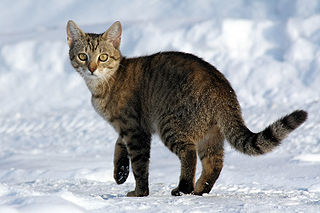

이 그림에 대해 설명해 주세요?

-------Response--------
눈 속에 서 있는 고양이의 사진입니다. 고양이는 얼룩덜룩한 회색과 갈색의 털을 가지고 있으며 노란색 눈을 가지고 있습니다. 고양이는 카메라를 바라보고 있습니다. 눈 속에는 고양이 발자국이 있습니다.


In [ ]:
gcs_uri = "gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg"
get_gcs_image(gcs_uri)

# Load from local file
image = Image.load_from_file("image.jpg")

# Prepare contents
prompt = "이 그림에 대해 설명해 주세요?"
contents = [image, prompt]

response = model.generate_content(contents)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
print(response.text)

-------Prompt--------
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83606  100 83606    0     0   539k      0 --:--:-- --:--:-- --:--:--  537k


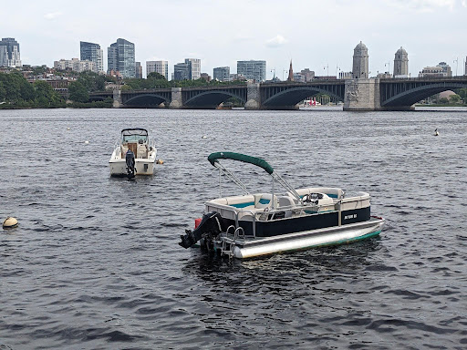

그림에 대한 상황을 설명해 주소 어울리는 옷 추천해줘?

-------Response--------
 사진은 강에 두 척의 보트가 떠 있는 모습을 보여줍니다. 오른쪽 보트는 폰툰 보트이고 왼쪽 보트는 소형 모터보트입니다. 보트는 강가에 있는 도시의 스카이라인을 배경으로 하고 있습니다.

이 사진을 찍은 사람은 보트를 타고 강에서 휴식을 취하고 있는 것 같습니다. 날씨가 좋아 보이고 수면이 잔잔해서 보트를 타기에 완벽한 날입니다.

옷을 추천해 달라고 하셨는데, 사진에 나온 사람이 없어서 어떤 옷을 입어야 할지 모르겠습니다. 다만, 날씨가 좋아 보이니 반바지와 티셔츠를 입으면 좋을 것 같습니다. 😉

In [ ]:
# Load image from Cloud Storage URI
gcs_uri = "gs://cloud-samples-data/generative-ai/image/boats.jpeg"

# Prepare contents
image = Part.from_uri(gcs_uri, mime_type="image/jpeg")
prompt = "그림에 대한 상황을 설명해 주고 어울리는 옷 추천해줘?"
contents = [image, prompt]

response = model.generate_content(contents)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
print(response.text, end="")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83606  100 83606    0     0   678k      0 --:--:-- --:--:-- --:--:--  680k
-------Prompt--------


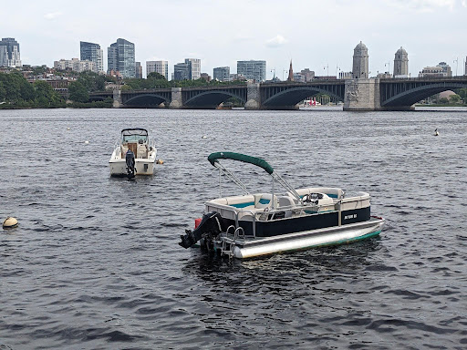

그림에 있는 도시가 어디인지 찾아줘?

-------Response--------
 이 사진은 보스턴 시내를 찰스 강 건너편에서 찍은 것입니다. 사진의 왼쪽에 있는 다리는 론스펠로우 다리이고, 오른쪽에 있는 다리는 보스턴 대학교 다리입니다. 사진 중앙에 있는 건물은 존 핸콕 타워입니다.

In [ ]:
# Load image from Cloud Storage URI
image_url = (
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/boats.jpeg"
)

# Prepare contents
image = download_image(image_url)
prompt = "그림에 있는 도시가 어디인지 찾아줘?"
contents = [image, prompt]

response = model.generate_content(contents)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
print(response.text, end="")